In [0]:
from google.colab import files
files.upload()

Saving kddcup.data_10_percent to kddcup.data_10_percent


In [0]:
!ls

kddcup.data_10_percent	sample_data


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import os
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 3.6.9 (default, Nov  7 2019 10:44:02)
SparkSession available as 'spark'.
# of connections: 494021


/content/spark-2.4.4-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


Time elapsed during training: 10.741289377212524


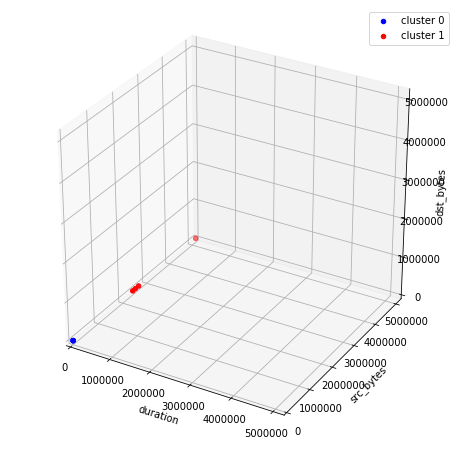

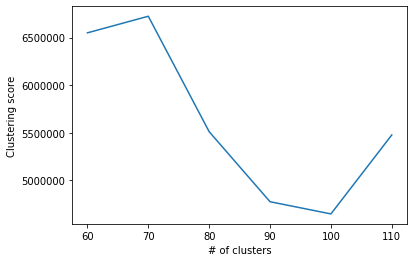

The min score is: 4645035.297572117
The best k is: 100


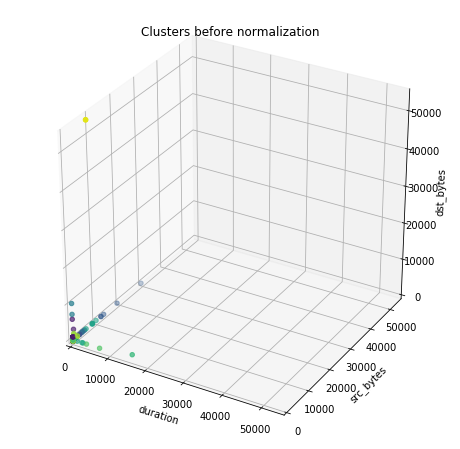

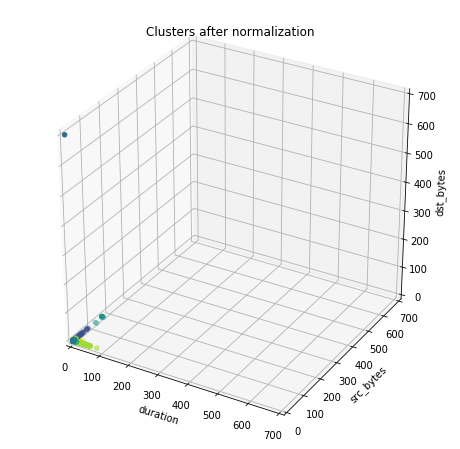

In [0]:
import os
import sys
import re
from time import time
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.shell import sc
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
# from pyspark.sql.functions import *
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from operator import add
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Function definitions ------------------------------------------------------------------------------------------------
# Read a comma delimited line of data
def parse_line(line):
    cols = line.split(',')
    label = cols[-1]
    vector = cols[:-1]
    vector = [element for i, element in enumerate(vector) if i not in [1, 2, 3]]
    vector = np.array(vector, dtype=np.float)
    return (label, vector)

# Get the 3 data fields that have the most variance
def get_vars(data):
    n = data.count()
    means = data.reduce(add)/n
    vars_ = data.map(lambda x: (x - means)**2).reduce(add)/n
    return vars_

# Euclidean distance function
def euclidean_distance(a, b):
    c = a - b
    return np.sqrt(c.T.dot(c))

# Get the clustering score of a potential k by evaluating the model with Within Set Sum of Squared Errors (WSSSE)
def clustering_score(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    WSSSE = clusters.computeCost(data)
    return WSSSE

# Apply a basic normalization function to the data to eliminate bias
def normalize_data(data):
    n = data.count()
    means = data.reduce(add)/n
    vars_ = data.map(lambda x: (x - means) ** 2).reduce(add)/n
    stdevs = np.sqrt(vars_)
    stdevs[stdevs == 0] = 1
    # Normalize a single data point
    def normalize(point):
        return (point - means)/stdevs

    return data.map(normalize)

# Calculate WSSSE using a different method which determines closest centers with euclidean distance
def get_WCSSE(clusters, data_point):
    closest_centroid = clusters.centers[clusters.predict(data_point)]
    return euclidean_distance(closest_centroid, data_point)**2

# Load the data and begin preparing it for clustering and anomaly detection -------------------------------------------
path = "kddcup.data_10_percent"
data = sc.textFile(path, 12)

# Parse the numerical data
labeled_data = data.map(parse_line).cache()
unlabeled_data = labeled_data.map(lambda row: row[1]).cache()
# Get the total number of data points (should be ~5 million)
n = unlabeled_data.count()
print("# of connections: {}".format(n))

# Train the kmeans model
t1 = time()
clusters = KMeans.train(unlabeled_data, 2, maxIterations=10, runs=10, initializationMode="random")
print("Time elapsed during training: {}".format(time() - t1))
print
# Select the 3 numerical data fields in the set with the most variance
vars_ = get_vars(unlabeled_data)
# Get the indices of the 3 data fields that vary the most
indices = [t[0] for t in sorted(enumerate(vars_), key=lambda x: x[1])[-3:]]
# Select a small amount of data to project and gather data points belonging to the two clusters
data_to_project = unlabeled_data.randomSplit([10, 90])[0]
rdd0 = unlabeled_data.filter(lambda point: clusters.predict(point)==0)
rdd1 = unlabeled_data.filter(lambda point: clusters.predict(point)==1)
# Store the centers of the clusters and take 5 data points from each one to project
center0 = clusters.centers[0]
center1 = clusters.centers[1]
cluster0 = rdd0.take(5)
cluster1 = rdd1.take(5)
# Project the data
cluster0_projected = np.array([[point[i] for i in indices] for point in cluster0])
cluster1_projected = np.array([[point[i] for i in indices] for point in cluster1])
# Take the min/max values from the clusters to use for the plot
maximum = max(max(cluster1_projected.flatten()), max(cluster0_projected.flatten()))
minimum = min(min(cluster1_projected.flatten()), min(cluster0_projected.flatten()))
# Plot the clusters in a plot where each axis is bounded by the min/max values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster0_projected[:, 0], cluster0_projected[:, 1], cluster0_projected[:, 2], c="b")
ax.scatter(cluster1_projected[:, 0], cluster1_projected[:, 1], cluster1_projected[:, 2], c="r")
ax.set_xlim(minimum, maximum)
ax.set_ylim(minimum, maximum)
ax.set_zlim(minimum, maximum)
ax.set_xlabel("duration")
ax.set_ylabel("src_bytes")
ax.set_zlabel("dst_bytes")
ax.legend(["cluster 0", "cluster 1"])
plt.show()
# Evaluate the trained model ------------------------------------------------------------------------------------------
# Normalize the data to produce better clusters and figure out the ideal K --------------------------------------------
# Retrieve the normalized data and set possible values for k as 60, 70, 80, 90, 100, 110
normalized_data = normalize_data(unlabeled_data).cache()
k_range = range(60, 111, 10)
# Calculate the clustering scores in order to determine the best k (the lowest score is the best k)
scores = [clustering_score(normalized_data, k) for k in k_range]
plt.plot(k_range, scores)
plt.xlabel("# of clusters")
plt.ylabel("Clustering score")
plt.show()
# Use 90 as default k, but try to get the best one
bestK = 90
min_score = np.amin(scores)
print("The min score is: {}".format(min_score))
for i in range(0, 5):
    if scores[i] == min_score:
        bestK = k_range[i]

print("The best k is: {}".format(bestK))
# Select the data to project and train the model
data_to_project = unlabeled_data.randomSplit([1, 999])[0].cache()
clusters = KMeans.train(unlabeled_data, bestK, maxIterations=10, runs=10, initializationMode="random")

data_to_project_list = data_to_project.collect()
data_projected = np.array([[point[i] for i in indices] for point in data_to_project_list])
labels = [clusters.predict(point) for point in data_to_project_list]

# Take the min and max again
maximum = max(data_projected.flatten())
minimum = min(data_projected.flatten())

# Show the plot of the clusters before normalization
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2], c=labels)
ax.set_xlim(minimum, maximum)
ax.set_ylim(minimum, maximum)
ax.set_zlim(minimum, maximum)
ax.set_xlabel("duration")
ax.set_ylabel("src_bytes")
ax.set_zlabel("dst_bytes")
ax.set_title("Clusters before normalization")
plt.show()

# Train a new model with the normalized data
clusters = KMeans.train(normalized_data, bestK, maxIterations=10, runs=10, initializationMode="random")
data_to_project_normed = normalize_data(unlabeled_data).cache()
data_to_project_normed = data_to_project_normed.collect()
data_projected = np.array([[point[i] for i in indices] for point in data_to_project_normed])
labels = [clusters.predict(point) for point in data_to_project_normed]

# Take the min and max for the normalized data
maximum = max(data_projected.flatten())
minimum = min(data_projected.flatten())

# Plot the new clusters after normalization
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2], c=labels)
ax.set_xlim(minimum, maximum)
ax.set_ylim(minimum, maximum)
ax.set_zlim(minimum, maximum)
ax.set_xlabel("duration")
ax.set_ylabel("src_bytes")
ax.set_zlabel("dst_bytes")
ax.set_title("Clusters after normalization")
plt.show()